## Q1: Read in the data and review the non-binary variables to see if any are skewed and need to be transformed. If so, transform them and drop the non-transformed versions of the variables. Make sure that you do not include the customer identifier id in your calculations. Explain what you found, what transformations you applied, and why.

1. Import Libraries to be used in this homework.

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

2. Read in the dataset.

In [60]:
lr = pd.read_csv('dmtrain.csv')
lr

,id,n24,rev24,revlast,elpsdm,ordfreq,ordcat,response
0,1,2,30.0,20.0,24,1,6,1
1,2,25,207.0,20.0,24,1,6,0
2,3,5,52.0,15.0,24,1,6,0
3,4,11,105.0,15.0,24,1,6,0
4,5,2,32.0,17.0,24,1,6,0
...,...,...,...,...,...,...,...,...
1995,1996,12,105.0,20.0,1,2,6,0
1996,1997,36,786.0,5.0,1,2,6,0
1997,1998,7,415.0,100.0,1,1,7,0
1998,1999,5,77.0,25.0,1,1,7,0


3. Create histograms to explore the distribution of the variables: 
 - n24
 - rev24
 - revlast
 - elpsdm
 - ordfreq
 - ordcat
 - response

Text(0.5, 1.0, 'ordcat')

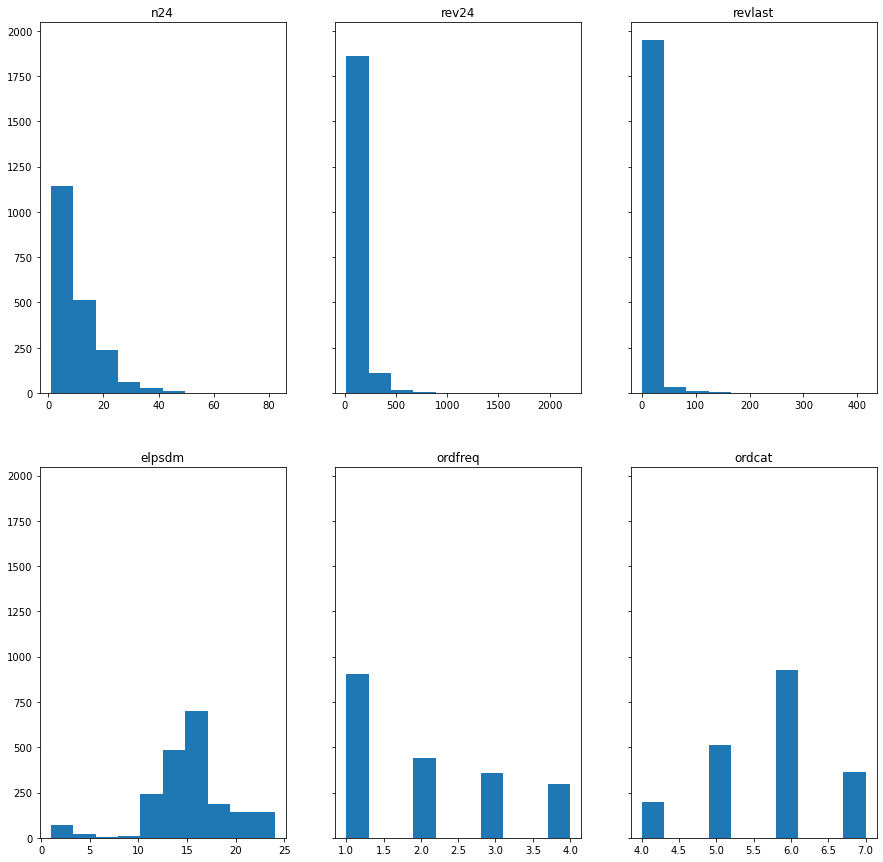

In [3]:
fig, axs = plt.subplots(2, 3, figsize=(15, 15), sharey=True)
#place each histogram, with corresponding titles.
axs[0,0].hist(lr['n24'])
axs[0,0].set_title("n24")
axs[0,1].hist(lr['rev24'])
axs[0,1].set_title("rev24")
axs[0,2].hist(lr['revlast'])
axs[0,2].set_title("revlast")
axs[1,0].hist(lr['elpsdm'])
axs[1,0].set_title("elpsdm")
axs[1,1].hist(lr['ordfreq'])
axs[1,1].set_title("ordfreq")
axs[1,2].hist(lr['ordcat'])
axs[1,2].set_title("ordcat")

We found that n24, rev24, revlast and ordfreq were all right skewed. 
However, before we apply a log transformation to the variables, we must take an extra step. 
Since revlast has rows with values = 0, log transforming them will take those values to infinity. Hence, we will remove those rows before transforming. 

3. We will now apply a log transformation to each of the skewed variables. 

In [4]:
#create a copy of our data to write over the skewed variables.
log_lr=lr.copy()
#log transform each variable and use their transformed versions to replace 
#their skewed counterparts
log_lr['n24'] = np.log(log_lr['n24'])
log_lr['rev24'] = np.log(log_lr['rev24'])
log_lr['revlast'] = np.log(log_lr['revlast'])
log_lr['ordfreq'] = np.log(log_lr['ordfreq'])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
log_lr = log_lr[np.isfinite(log_lr).all(1)]

In [6]:
log_lr=log_lr.reset_index() 
log_lr

,index,id,n24,rev24,revlast,elpsdm,ordfreq,ordcat,response
0,0,1,0.693147,3.401197,2.995732,24,0.000000,6,1
1,1,2,3.218876,5.332719,2.995732,24,0.000000,6,0
2,2,3,1.609438,3.951244,2.708050,24,0.000000,6,0
3,3,4,2.397895,4.653960,2.708050,24,0.000000,6,0
4,4,5,0.693147,3.465736,2.833213,24,0.000000,6,0
...,...,...,...,...,...,...,...,...,...
1987,1995,1996,2.484907,4.653960,2.995732,1,0.693147,6,0
1988,1996,1997,3.583519,6.666957,1.609438,1,0.693147,6,0
1989,1997,1998,1.945910,6.028279,4.605170,1,0.000000,7,0
1990,1998,1999,1.609438,4.343805,3.218876,1,0.000000,7,0


Text(0.5, 1.0, 'ordfreq log')

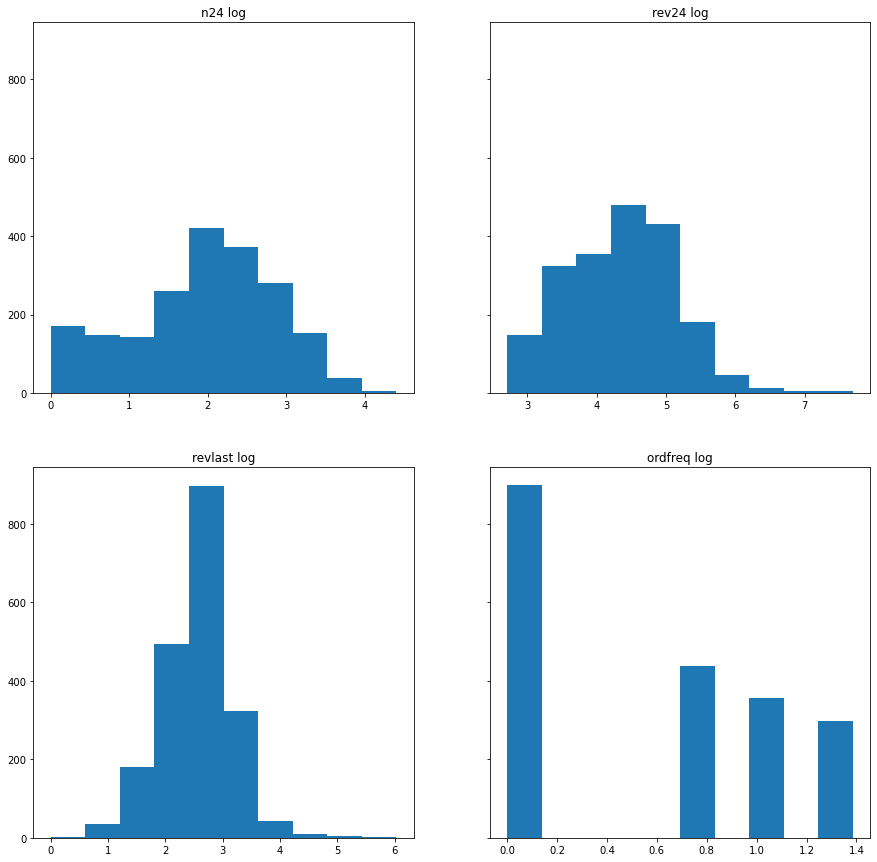

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), sharey=True)
axs[0,0].hist(log_lr['n24'])
axs[0,0].set_title("n24 log")
axs[0,1].hist(log_lr['rev24'])
axs[0,1].set_title("rev24 log")
axs[1,0].hist(log_lr['revlast'])
axs[1,0].set_title("revlast log")
axs[1,1].hist(log_lr['ordfreq'])
axs[1,1].set_title("ordfreq log")

## Q2: Generate a decision tree on the entire dataset, without any limitations on the depth of the tree. Use entropy as the metric. What is the depth of the tree that is generated? Provide a plot of the tree.

1. Designate X and y

In [8]:
#we kept getting an error that values in our database were infinite. hence, we will only take finite values into consideration as seen below

In [9]:
log_lr = log_lr[np.isfinite(log_lr).all(1)]

In [10]:
log_lr

,index,id,n24,rev24,revlast,elpsdm,ordfreq,ordcat,response
0,0,1,0.693147,3.401197,2.995732,24,0.000000,6,1
1,1,2,3.218876,5.332719,2.995732,24,0.000000,6,0
2,2,3,1.609438,3.951244,2.708050,24,0.000000,6,0
3,3,4,2.397895,4.653960,2.708050,24,0.000000,6,0
4,4,5,0.693147,3.465736,2.833213,24,0.000000,6,0
...,...,...,...,...,...,...,...,...,...
1987,1995,1996,2.484907,4.653960,2.995732,1,0.693147,6,0
1988,1996,1997,3.583519,6.666957,1.609438,1,0.693147,6,0
1989,1997,1998,1.945910,6.028279,4.605170,1,0.000000,7,0
1990,1998,1999,1.609438,4.343805,3.218876,1,0.000000,7,0


In [139]:
X = log_lr.copy()
X= X.drop(['index'], axis=1)
X = X.drop(['id','response'], axis = 1).to_numpy()
y = log_lr['response'].to_numpy()

array([[ 0.69314718,  3.40119738,  2.99573227, 24.        ,  0.        ,
         6.        ],
       [ 3.21887582,  5.33271879,  2.99573227, 24.        ,  0.        ,
         6.        ],
       [ 1.60943791,  3.95124372,  2.7080502 , 24.        ,  0.        ,
         6.        ],
       ...,
       [ 1.94591015,  6.02827852,  4.60517019,  1.        ,  0.        ,
         7.        ],
       [ 1.60943791,  4.34380542,  3.21887582,  1.        ,  0.        ,
         7.        ],
       [ 3.52636052,  6.15060277,  3.4339872 ,  1.        ,  0.        ,
         6.        ]])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [13]:
dtree=DecisionTreeClassifier(criterion = 'entropy')
dtree.fit(X_train,y_train)
print('Decision Tree Classifier Created')

Decision Tree Classifier Created


In [14]:
dtree.get_depth()

25

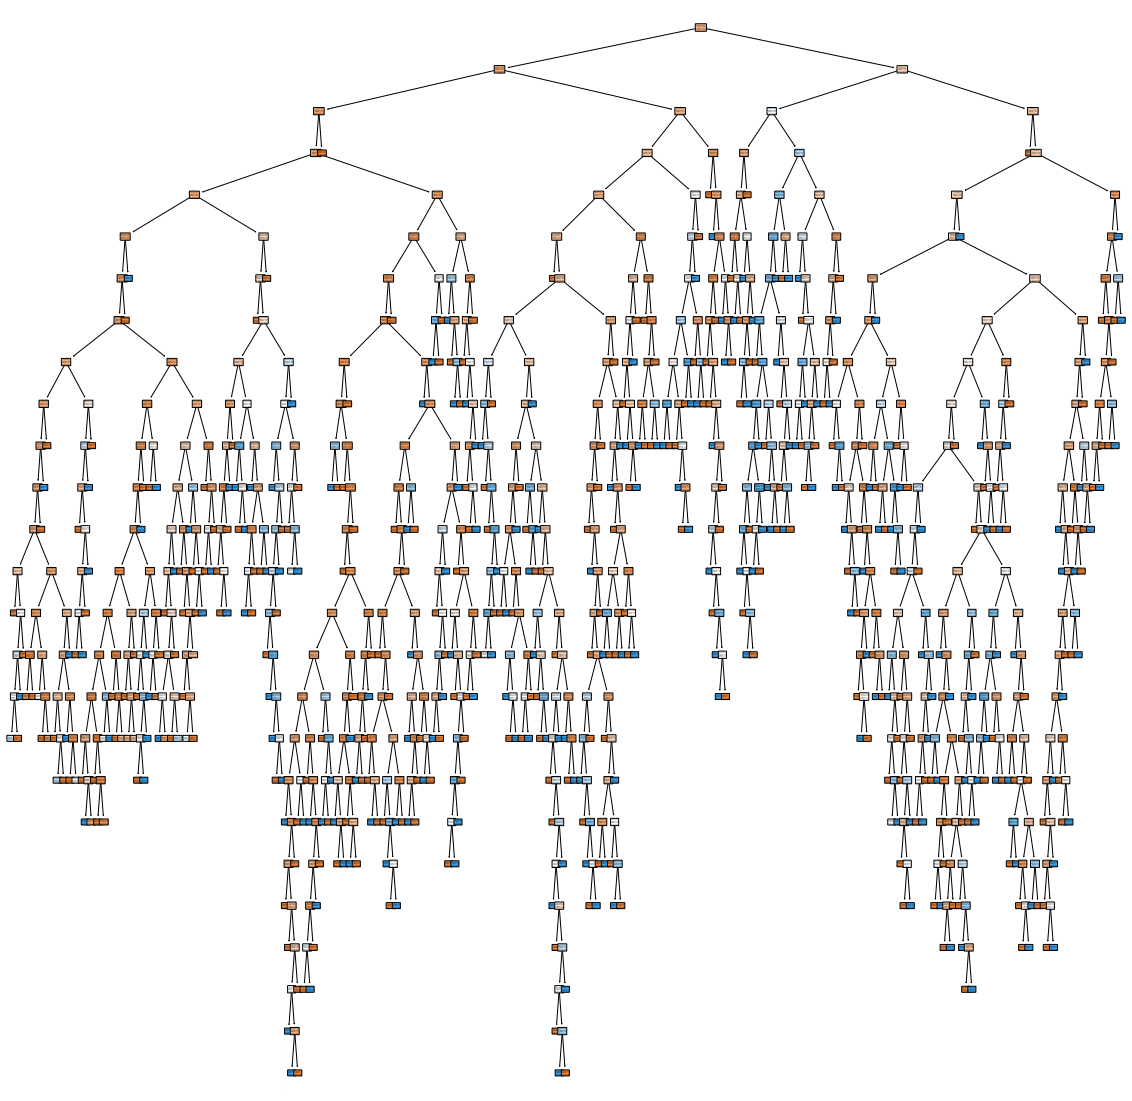

In [15]:
plt.figure(figsize = (20,20))
dec_tree = plot_tree(decision_tree=dtree, feature_names = log_lr.columns, class_names = ['no', 'yes'],
                     filled = True , rounded = True)

## Q3: We will focus on decision trees first, and try to identify the best decision tree classifier by pruning the tree at different depths. Use 10-fold cross validation and identify the best tree depth (again, using accuracy as the metric), by trying as many possible depths as you deem necessary. Provide your reasoning for using the values of tree-depth that you tried. Based on your results, what depth do you recommend? What is the accuracy associated with this tree depth? If you had to select the three best values of tree-depth, what would they be?

1. Specifying k-fold where k=10

In [16]:
kf =KFold(n_splits=10, shuffle=True, random_state=1)
print(kf)

KFold(n_splits=10, random_state=1, shuffle=True)


2. Creating the decision tree models with different max_depth's and storing them in a dataframe

In [17]:
#create empty df for all different DT classifiers and their different tree depths
modelsDT = []
modelsDT.append(('DT20', DecisionTreeClassifier(criterion = 'entropy', max_depth = 20, random_state=1)))
modelsDT.append(('DT19', DecisionTreeClassifier(criterion = 'entropy', max_depth = 19, random_state=1)))
modelsDT.append(('DT18', DecisionTreeClassifier(criterion = 'entropy', max_depth = 18, random_state=1)))
modelsDT.append(('DT17', DecisionTreeClassifier(criterion = 'entropy', max_depth = 17, random_state=1)))
modelsDT.append(('DT16', DecisionTreeClassifier(criterion = 'entropy', max_depth = 16, random_state=1)))
modelsDT.append(('DT15', DecisionTreeClassifier(criterion = 'entropy', max_depth = 15, random_state=1)))
modelsDT.append(('DT14', DecisionTreeClassifier(criterion = 'entropy', max_depth = 14, random_state=1)))
modelsDT.append(('DT13', DecisionTreeClassifier(criterion = 'entropy', max_depth = 13, random_state=1)))
modelsDT.append(('DT12', DecisionTreeClassifier(criterion = 'entropy', max_depth = 12, random_state=1)))
modelsDT.append(('DT11', DecisionTreeClassifier(criterion = 'entropy', max_depth = 11, random_state=1)))
modelsDT.append(('DT10', DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, random_state=1)))
modelsDT.append(('DT9', DecisionTreeClassifier(criterion = 'entropy', max_depth = 9, random_state=1)))
modelsDT.append(('DT8', DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, random_state=1)))
modelsDT.append(('DT7', DecisionTreeClassifier(criterion = 'entropy', max_depth = 7, random_state=1)))
modelsDT.append(('DT6', DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, random_state=1)))
modelsDT.append(('DT5', DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, random_state=1)))
modelsDT.append(('DT4', DecisionTreeClassifier(criterion = 'entropy', max_depth = 4, random_state=1)))
modelsDT.append(('DT3', DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state=1)))
modelsDT.append(('DT2', DecisionTreeClassifier(criterion = 'entropy', max_depth = 2, random_state=1)))

3. Check accuracy in all DT models

In [18]:
metric = 'accuracy'
resultsA = []
mIDsA = []
for mID, mdl in modelsDT:
    kf = model_selection.StratifiedKFold(n_splits=10)
    cvres = model_selection.cross_val_score(mdl, X_train, y_train, cv=kf, scoring=metric)
    resultsA.append(cvres)
    mIDsA.append(mID)
    print("%s: %3f (%3f)" % (mID, cvres.mean(), cvres.std()))

DT20: 0.630224 (0.032649)
DT19: 0.630865 (0.027744)
DT18: 0.635263 (0.025717)
DT17: 0.631486 (0.025202)
DT16: 0.634650 (0.021739)
DT15: 0.641533 (0.025502)
DT14: 0.641545 (0.025372)
DT13: 0.649741 (0.025212)
DT12: 0.650350 (0.026439)
DT11: 0.663538 (0.030830)
DT10: 0.669182 (0.032979)
DT9: 0.682976 (0.025325)
DT8: 0.686753 (0.017406)
DT7: 0.694921 (0.016305)
DT6: 0.701832 (0.014127)
DT5: 0.704344 (0.013301)
DT4: 0.704969 (0.017116)
DT3: 0.716266 (0.012323)
DT2: 0.709379 (0.017275)


4. create box plot to visualize results

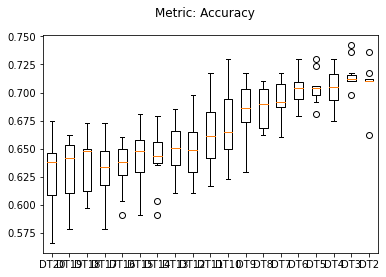

In [19]:
fig = plt.figure()
fig.suptitle('Metric: Accuracy')
ax = fig.add_subplot(1,1,1)
plt.boxplot(resultsA)
ax.set_xticklabels(mIDsA)
plt.show()

## Q4: Next, we will consider random forests. Develop a random forest classifiers with 100 trees, using the three best values of tree-depth you identified in the previous question. Provide all relevant results. Which tree-depth results in the best random forest classifier? How does it perform relative to the best decision tree?

In [20]:
rf=RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
rf.fit(X_train,y_train)
print('Random Forest Classifier Created')

Random Forest Classifier Created


In [21]:
#create empty df for all different DT classifiers and their different tree depths
modelsRF = []
modelsRF.append(('RF3', RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 3, random_state=1)))
modelsRF.append(('RF2', RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 2, random_state=1)))
modelsRF.append(('RF4', RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 4, random_state=1)))

In [22]:
metric = 'accuracy'
resultsA = []
mIDsA = []
for mID, mdl in modelsRF:
    kf = model_selection.StratifiedKFold(n_splits=10)
    cvres = model_selection.cross_val_score(mdl, X_train, y_train, cv=kf, scoring=metric)
    resultsA.append(cvres)
    mIDsA.append(mID)
    print("%s: %3f (%3f)" % (mID, cvres.mean(), cvres.std()))

RF3: 0.717512 (0.009777)
RF2: 0.713750 (0.002730)
RF4: 0.725672 (0.010944)


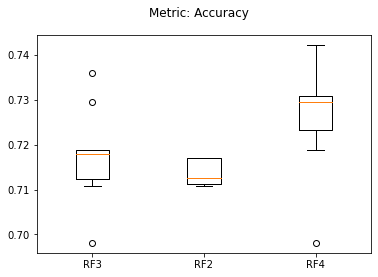

In [23]:
fig = plt.figure()
fig.suptitle('Metric: Accuracy')
ax = fig.add_subplot(1,1,1)
plt.boxplot(resultsA)
ax.set_xticklabels(mIDsA)
plt.show()

The best Random Forest model had a tree depth = 4. This model performs almost a whole 1% better (0.725672) than the best model we crafted for the classic Classification Tree with tree depth =3 (0.716266). In fact, the accuracy of ALL the Random Forest models we tested were HIGHER than ALL results from the classic Decision Trees. 

## Q5: Repeat this experiment with 50 trees. Provide all relevant results. Does your recommendation change?

In [24]:
modelsRF2 = []
modelsRF2.append(('RF3.1', RandomForestClassifier(n_estimators = 50, criterion = 'entropy', max_depth = 3, random_state=1)))
modelsRF2.append(('RF2.1', RandomForestClassifier(n_estimators = 50, criterion = 'entropy', max_depth = 2, random_state=1)))
modelsRF2.append(('RF4.1', RandomForestClassifier(n_estimators = 50, criterion = 'entropy', max_depth = 4, random_state=1)))

In [25]:
metric = 'accuracy'
resultsA = []
mIDsA = []
for mID, mdl in modelsRF2:
    kf = model_selection.StratifiedKFold(n_splits=10)
    cvres = model_selection.cross_val_score(mdl, X_train, y_train, cv=kf, scoring=metric)
    resultsA.append(cvres)
    mIDsA.append(mID)
    print("%s: %3f (%3f)" % (mID, cvres.mean(), cvres.std()))

RF3.1: 0.715637 (0.010718)
RF2.1: 0.714379 (0.003883)
RF4.1: 0.724418 (0.009918)


No, our recommendation remains that Random Forests with n=100 and and tree depth =4 is the best model. Even if we were to choose a Random Forests model with n=50, the best tree depth remains 4. 

## Q6: We will now consider k-nearest neighbor models. Use 10-fold cross validation and identify the best value of k, by trying as many values of k as necessary. Keep in mind that very large values of k can affect speed, and that 5 is the default – try at least values from 5 to 10 (you can try more if you wish). Provide all relevant results. What value of k do you recommend? What is the accuracy associated with this value of k? If you had to select the three best values of k, what would they be?

In [26]:
modelsKNN =[]
modelsKNN.append(('KN5', KNeighborsClassifier(n_neighbors=5)))
modelsKNN.append(('KN6', KNeighborsClassifier(n_neighbors=6)))
modelsKNN.append(('KN7', KNeighborsClassifier(n_neighbors=7)))
modelsKNN.append(('KN8', KNeighborsClassifier(n_neighbors=8)))
modelsKNN.append(('KN9', KNeighborsClassifier(n_neighbors=9)))
modelsKNN.append(('KN10', KNeighborsClassifier(n_neighbors=10)))
modelsKNN.append(('KN11', KNeighborsClassifier(n_neighbors=11)))
modelsKNN.append(('KN12', KNeighborsClassifier(n_neighbors=12)))
modelsKNN.append(('KN13', KNeighborsClassifier(n_neighbors=13)))
modelsKNN.append(('KN14', KNeighborsClassifier(n_neighbors=14)))

In [27]:
metric = 'accuracy'
resultsA = []
mIDsA = []
for mID, mdl in modelsKNN:
    kf = model_selection.StratifiedKFold(n_splits=10)
    cvres = model_selection.cross_val_score(mdl, X, y, cv=kf, scoring=metric)
    resultsA.append(cvres)
    mIDsA.append(mID)
    print("%s: %3f (%3f)" % (mID, cvres.mean(), cvres.std()))

KN5: 0.548148 (0.118491)
KN6: 0.594354 (0.111941)
KN7: 0.553183 (0.113500)
KN8: 0.585817 (0.112653)
KN9: 0.554178 (0.119146)
KN10: 0.587332 (0.098201)
KN11: 0.551688 (0.108797)
KN12: 0.592362 (0.087573)
KN13: 0.574791 (0.093208)
KN14: 0.605420 (0.066991)


## Q7: Develop a logistic regression model using 10-fold cross validation. What is the associated accuracy?

In [28]:
modelsLR = []
modelsLR.append(('LR', LogisticRegression()))

In [29]:
metric = 'accuracy'
resultsA = []
mIDsA = []
for mID, mdl in modelsLR:
    kf = model_selection.StratifiedKFold(n_splits=10)
    cvres = model_selection.cross_val_score(mdl, X, y, cv=kf, scoring=metric)
    resultsA.append(cvres)
    mIDsA.append(mID)
    print("%s: %3f (%3f)" % (mID, cvres.mean(), cvres.std()))

LR: 0.711852 (0.006205)


## Q8: Develop a logistic regression model on the entire training dataset. Provide the output. What is the model developed?

In [30]:
LR = LogisticRegression(random_state=1).fit(X_train, y_train)
LR.score(X, y)

##get the equation
LR.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## Q9: Using the four best models identified in each category (decision tree, random forest, k-nearest neighbor, logistic regression), perform an  evaluation with 10-fold cross-validation. Your results should be similar (but not necessarily identical) to the results you have already obtained for these models. Across these four models, which one would you recommend, and why?

In [31]:
modelsFINAL=[]
modelsFINAL.append(('KN12', KNeighborsClassifier(n_neighbors=12)))
modelsFINAL.append(('RF4.1', RandomForestClassifier(n_estimators = 50, criterion = 'entropy', max_depth = 4)))
modelsFINAL.append(('RF4', RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth = 4)))
modelsFINAL.append(('DT3', DecisionTreeClassifier(criterion = 'entropy', max_depth = 3)))
modelsFINAL.append(('LR', LogisticRegression()))

In [32]:
metric = 'accuracy'
resultsA = []
mIDsA = []
for mID, mdl in modelsFINAL:
    kf = model_selection.StratifiedKFold(n_splits=10)
    cvres = model_selection.cross_val_score(mdl, X, y, cv=kf, scoring=metric)
    resultsA.append(cvres)
    mIDsA.append(mID)
    print("%s: %3f (%3f)" % (mID, cvres.mean(), cvres.std()))

KN12: 0.592362 (0.087573)
RF4.1: 0.705319 (0.006448)
RF4: 0.707329 (0.008102)
DT3: 0.691261 (0.024369)
LR: 0.711852 (0.006205)


## Q10: Use the entire dataset to develop a final version of the recommended model for testing. Provide all details of the model (and the tree if the recommended model is the decision tree). What is that accuracy of this model on the training dataset?

In [145]:
LR = LogisticRegression(random_state=1).fit(X, y)
LR.score(X, y)

0.7143574297188755

In [146]:
##get the equation
LR.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## Q11: Read the file dmtest.csv and make predictions (using the final model) on which customers are likely to respond, and which are not. The predictions have to be 0 or 1 – if the model you selected naturally gives a probability score, use 0.5 as the threshold to determine whether your prediction will be 0 or 1. For example, if you use a logistic regression model that gives you a probability estimate of 0.51, the prediction should be 1, and if it gives a a probability estimate of 0.49, the prediction should be 0. Create a file groupxxdmtest.csv that adds a column named “prediction” to the original variables in dmtest.csv and submit it with your report. I will assess the quality of your predictions based on the actual values (which are not included in dmtest.csv).

In [119]:
df2 = pd.read_csv("dmtest.csv")
df2.drop(['id'],axis=1,inplace=True)
df2['revlast'] = df2['revlast'].replace(0,0.000001)
df2['n24'] = np.log(df2['n24'])
df2['rev24'] = np.log(df2['rev24'])
df2['revlast'] = np.log(df2['revlast'])
df2['ordfreq'] = np.log(df2['ordfreq'])

In [120]:
df2

,n24,rev24,revlast,elpsdm,ordfreq,ordcat
0,1.609438,5.225747,2.890372,24,0.000000,6
1,0.693147,3.401197,2.708050,24,0.000000,6
2,3.178054,5.891644,3.401197,24,0.000000,7
3,1.386294,3.713572,2.708050,24,0.000000,6
4,1.609438,4.077537,2.890372,24,0.000000,6
...,...,...,...,...,...,...
1995,2.197225,5.105945,-13.815511,1,0.000000,7
1996,2.397895,5.003946,2.708050,1,1.098612,6
1997,2.890372,5.081404,2.564949,1,0.693147,5
1998,3.258097,6.056784,3.218876,1,1.386294,7


In [121]:
logistic_regression = LogisticRegression().fit(X,y)
probabilities = logistic_regression.predict_proba(df2)
result_arr = []
for i in probabilities:
    if i[1] >= 0.5:
        result_arr.append(1)
    else:
        result_arr.append(0)
result_arr

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [122]:
from collections import Counter
Counter(result_arr)

Counter({0: 1962, 1: 38})

In [123]:
ans_df = pd.DataFrame(result_arr,columns=["prediction"])
df2 ["prediction"] = ans_df
df2.to_csv("group01dmtest.csv", encoding='utf-8', index=False)
df3=pd.read_csv('group01dmtest.csv')
df3

,n24,rev24,revlast,elpsdm,ordfreq,ordcat,prediction
0,1.609438,5.225747,2.890372,24,0.000000,6,0
1,0.693147,3.401197,2.708050,24,0.000000,6,0
2,3.178054,5.891644,3.401197,24,0.000000,7,0
3,1.386294,3.713572,2.708050,24,0.000000,6,0
4,1.609438,4.077537,2.890372,24,0.000000,6,0
...,...,...,...,...,...,...,...
1995,2.197225,5.105945,-13.815511,1,0.000000,7,1
1996,2.397895,5.003946,2.708050,1,1.098612,6,0
1997,2.890372,5.081404,2.564949,1,0.693147,5,0
1998,3.258097,6.056784,3.218876,1,1.386294,7,0


## Q12: If you were to focus on the “lapsing customers” (customers who made their last purchase 13 to 24 months ago) do you expect your model to be different? For the selected model, compare the quality of predictions for these customers relative to predictions for the others on records in the training set. Discuss your findings.

In [155]:
lr2=lr.copy()
lr2 = lr2.drop(lr2[lr2.revlast < 13].index)
lr2 = lr2.drop(lr2[lr2.revlast > 24].index)

In [161]:
X = lr2.copy()
X = X.drop(['id','response'], axis = 1).to_numpy()
y = lr2['response'].to_numpy()

In [162]:
X

array([[  2.,  30.,  20.,  24.,   1.,   6.],
       [ 25., 207.,  20.,  24.,   1.,   6.],
       [  5.,  52.,  15.,  24.,   1.,   6.],
       ...,
       [ 22., 218.,  15.,   1.,   2.,   5.],
       [  7.,  64.,  15.,   1.,   4.,   5.],
       [ 12., 105.,  20.,   1.,   2.,   6.]])

In [163]:
lr2.drop(['id','response'],axis=1,inplace=True)
lr2['n24'] = np.log(lr2['n24'])
lr2['rev24'] = np.log(lr2['rev24'])
lr2['revlast'] = np.log(lr2['revlast'])
lr2['ordfreq'] = np.log(lr2['ordfreq'])

In [168]:
LR = LogisticRegression(random_state=1).fit(X, y)
LR.score(X, y)

0.7448979591836735